# Coursera Machine Learning by Andrew Ng
## Programming Assignment6: Regularized Linear Regression and Bias v.s. Variance
본 과제는 매트랩으로 진행되는 과제이나, 매트랩에 익숙하지 않은 관계로 파이썬으로 구현하였다.

과제 설명 파일에 제시된 부분을 구현하였다. 과제 설명과 매트랩 파일의 힌트를 참고하였다. 이번 주차는 매트랩 파일에 작성된 코드의 난이도가 저번보다 다소 높아져서 약간 귀찮았다. 앞으로는 매트랩으로 짜는게 빠를수도 있겠다는 생각이 든다...

**보고서 대신 코드와 설명, 주석을 함께 작성한 해당 파일을 첨부드립니다.**

## Introduction
* regularized linear regression 구현
* 다른 bias-variance 특성을 갖는 모델 공부

### Files included
* ex5data1.mat - 데이터셋.
* 구현해야 할 것
    * linearRegCostFunction.m : regularized 선형 회귀의 비용 함수
    * learningCurve.m : 러닝 커브 만들기
    * polyFeatures.m : polynomial feature space의 Maps data
    * validationCurve.m : cross-validation curve

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Regularized Liner Regression
댐 물 수위를 조정해서 댐에서 방출되는 물의 양을 예측

* regularized linear regression 구현
* learning algorithm을 디버깅하여 bias vs variance의 효과 검토

### 1.1 Visualiaing the dataset
데이터셋 구조

* training set X, y
* cross validation set Xval, yval (regularized params 결정)
* test set Xtest, ytest

In [3]:
# Part 1 : Loading and Visualizing Data
print('Loding and Visualizing Data')

mat_data = io.loadmat('ex5data1.mat')

X = mat_data['X']
y = mat_data['y']
print(X.shape, y.shape)

Loding and Visualizing Data
(12, 1) (12, 1)


In [4]:
y = y.ravel() # (12, 1)의 2차원 배열을 (12, )의 1차원 배열로 변환
print(y.shape)

(12,)


In [5]:
Xval = mat_data['Xval']
yval = mat_data['yval'].ravel()
print(Xval.shape, yval.shape)

(21, 1) (21,)


In [6]:
Xtest = mat_data['Xtest']
ytest = mat_data['ytest'].ravel()
print(Xtest.shape, ytest.shape)

(21, 1) (21,)


Text(0, 0.5, 'Water flowing out of the damn (y)')

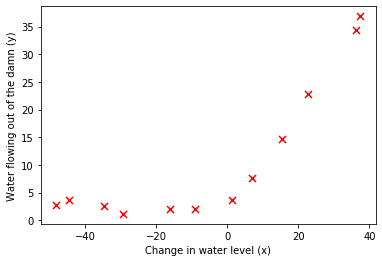

In [7]:
m = X.shape[0]

plt.scatter(X, y, c='red', marker='x', s=50)
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the damn (y)')

### 1.2 Regulized linear regression
[수식 이미지 넣기]

* lambda : regularization parameter
* regularization은 전체 cost J에 penalty를 부여한다. 모델 파라미터 Theta(j) 값이 커질수록 패널티가 증가한다.
* Theta(0)는 regularize하면 안된다.
* 코드를 vectorize해라.
* [1,1]로 초기화된 theta를 사용해서 cost 함수를 실행하면 **출력이 303.993이 나와야 한다.**

In [12]:
# Part 2 : Regualarized Linear Regression Cost

def linearRegCostFunction(X, y, theta, lambda_):
    m = X.shape[0]
    
    J = 0
    grad = np.zeros(np.size(theta))
    
    pred = X.dot(theta)
    
    J = 1 / (2*m) * np.sum((pred-y)**2)
    
    # regularization term
    sum_theta_sqr = np.sum(np.sum(theta[1:] ** 2))
    reg = lambda_ / (2*m) * sum_theta_sqr
    
    J = J+reg
    
    delta_zero = 1/m * (pred-y).dot(X[:,0]) #X의 첫번째 bias에 대해서 계산
    delta = 1/m * (pred-y).dot(X[:,1])
    regular = lambda_/m * theta[1:]
    delta_j = delta.T + regular
    
    grad = np.append(delta_zero, delta_j)
    
    return J, grad
    
theta = np.array([1,1])
X_temp = np.column_stack((np.ones(m), X))
J, grad = linearRegCostFunction(X_temp, y, theta, 1)

print(f'Cost at theta [1;1] : {J}')

Cost at theta [1;1] : 303.9931922202643


### 1.3 Regularized linear regression gradient

* linearRegCostFunction에서 gradient를 계산하는 코드 추가 및 grad에 넣어 반환
* [1;1]로 초기화된 theta를 사용해서 gradient 함수를 실행하면 gradient는 **[-15.30; 598.250]이어야 한다.**

In [13]:
print(f'Gradient at theta [1;1] : {grad[0]} {grad[1]}')

Gradient at theta [1;1] : -15.303015674201184 598.2507441727035


### 1.4 Fitting linear regression
* cost와 gradient 가 올바르게 작동하면, trainLinearReg.m을 실행해서 theta으 ㅣ최적값을 계산.
    * train 함수는 cost 함수를 최적화하기 위해 fmincg를 사용.
* 우리는 regularization parameter lambda를 0으로 설정.
    * 2차원 theta를 fit. 
    * regularization은 낮은 차원의 theta에 크게 도움이 되지는 않는다.
    * 따라서 polynomial 다항식 regression을 사용할 것임.
* `ex5.m` 스크립트는 best fit line을 그리는데, Figure 2와 같다.(선형 line)
    * 이 best fit line은 모델이 데이터에 적합하지 않다는 것을 말해준다.
    * 데이터가 non-linear pattern이기 때문.
* best fit을 visualization하는 것은 learning algorithm을 debug하는 한 가지 방법이다.
    * 그러나 데이터와 모델을 가시화 하는 것이 항상 쉬운 것은 아님.
    * 이따가 learning curve를 생성하는 함수를 구현한다. 이는 visulazation이 어려워도 learning algorithm을 debug하는 데 도움을 준다.

In [14]:
# Part 4 : Train linear regression
# Note : Data가 non-linear하기 때문에 훌륭하게 fit 되지 않음.

# 우선 fminunc 대신 minimize 기능을 제공하는 scipy 라이브러리를 임포트함.
from scipy.optimize import minimize

In [19]:
def trainLinearReg(X, y, lambda_, method='CG', maxiter=200):
    init_theta = np.zeros(X.shape[1])
    
    costFunc = lambda t: linearRegCostFunction(X, y, t, lambda_)[0]
    gradFunc = lambda t: linearRegCostFunction(X, y, t, lambda_)[1]
    
    res = minimize(fun=costFunc, x0=init_theta, method=method, jac=None, options={'disp': False, 'maxiter': maxiter})
    
    theta = res.x
    
    return theta

lambda_ = 0
theta = trainLinearReg(X_temp, y, lambda_)
print(theta)

[13.0878989   0.36777919]


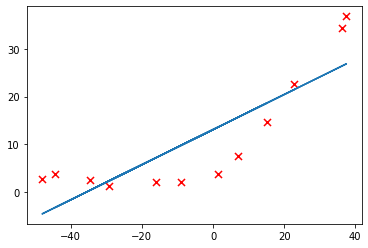

In [20]:
plt.scatter(X, y, c='red', marker='x', s=50)
plot(X, X_temp.dot(theta), '-')
plt.show()

## 2. Bias-variance
bias-variance 문제를 진단하기 위해 learning curve 상에서 train-test error 그림.

### 2.1 Learning curves
* learningCurve.m이 train set과 cross validation set의 error vector를 반환하게 구현.
* training error는 regularization term을 포함하지 않는다.
    * cost 함수를 사용하고 lambda를 0으로 설정.
* Figure 3에서 training example이 증가함에 따라 train error, cross validation error 모두 높아짐.
    * 모델이 high-bias하다.

In [22]:
# Part 5 : Learning curve for Linear regression
def learningCurve(X, y, Xval, yval, lambda_):
    m = X.shape[0]
    
    # 변수 초기화
    train_err = np.zeros(m)
    val_err = np.zeros(m)
    
    # X에 bias 컴럼 추가
    for i in np.arange(m):
        X_train = X[0:i + 1, :]
        y_train = y[0:i + 1]
        
        theta = trainLinearReg(X_train, y_train, lambda_)
        
        J = linearRegCostFunction(X_train, y_train, theta, 0)[0]
        train_err[i] = J
        
        J = linearRegCostFunction(Xval, yval, theta, 0)[0]
        val_err[i] = J
    
    return train_err, val_err


In [28]:
lambda_ = 0

Xval_temp = np.column_stack((np.ones((Xval.shape[0])), Xval))
train_err, val_err = learningCurve(X_temp, y, Xval_temp, yval, lambda_)

print('Train Examples\tTrain Error\tCross Validation Error')
for i in np.arange(m):
    print('%d\t\t%f\t\t%f' % (i, train_err[i], val_err[i]))

Train Examples	Train Error	Cross Validation Error
0		0.000000		205.121097
1		0.000000		110.300407
2		3.286595		45.010229
3		2.842678		48.368911
4		13.154049		35.865163
5		19.443963		33.829961
6		20.098522		31.970987
7		18.172859		30.862446
8		22.609405		31.135998
9		23.261462		28.936207
10		24.317250		29.551431
11		22.373906		29.433824


Text(0, 0.5, 'Err')

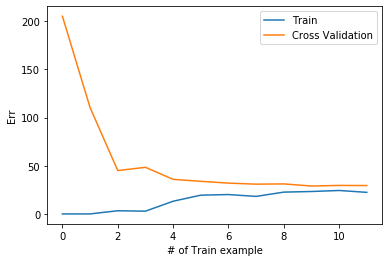

In [31]:
plot(np.arange(m), train_err, np.arange(m), val_err)
plt.legend(('Train', 'Cross Validation'))
plt.xlabel('# of Train example')
plt.ylabel('Err')

## 3. Polynomial regression

In [32]:
# Part 6 : Feature Mapping for polynomial regression

def featureNormalize(X):
    mu = np.mean(X, 0)
    sigma = np.std(X, axis=0, ddof=1)
    
    X_norm = (X-mu) / sigma
    
    return X_norm, mu, sigma

In [33]:
def polyFeatures(X, p):
    X_poly = np.zeros((np.size(X), p))
    
    for i in np.arange(p):
        X_poly[:, i] = X[:, 0]**(i+1)
        
    return X_poly

In [36]:
p=8

X_poly = polyFeatures(X, p)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.column_stack((np.ones(m), X_poly))

X_poly_test = polyFeatures(Xtest, p)
X_poly_test = (X_poly_test - mu) / sigma
X_poly_test = np.column_stack((np.ones(X_poly_test.shape[0]), X_poly_test))

X_poly_val = polyFeatures(Xval, p)
X_poly_val = (X_poly_val - mu) / sigma
X_poly_val = np.column_stack((np.ones(X_poly_val.shape[0]), X_poly_val))

print('Test : Normalized Training Example 1')
print('%s' % X_poly[0, :])
print()
print('%s' % X_poly[m-1, :])

Test : Normalized Training Example 1
[ 1.         -0.36214078 -0.75508669  0.18222588 -0.70618991  0.30661792
 -0.59087767  0.3445158  -0.50848117]

[ 1.          0.92937531 -0.41980793  0.51096837 -0.58862381  0.38261573
 -0.55903     0.36183236 -0.5006648 ]


### 3.1 Learning Polynomial Regression

### 3.2 Optional exercise : Adjusting the regularization parameter